<a href="https://colab.research.google.com/github/jtwang1027/cancer_omics/blob/master/2A_elastic_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_regression

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import PCA

In [0]:
au= pd.read_csv('/content/drive/My Drive/hcc1599.csv') # read in data from example cell line

In [0]:
au.dropna(axis=1, inplace=True)
encoded=pd.get_dummies(au.treatment, drop_first=True) #one hot encoding on treatments
au=au.join(encoded)
dropcol= ['cellID', 'fileID', 'cell_line','treatment']
au.drop(  dropcol , axis=1, inplace=True)


X= au.drop(['p.STAT5'], axis=1)
y= au['p.STAT5']

In [0]:
scaler=MinMaxScaler()
sub_col=['b.CATENIN', 'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67',
       'p.4EBP1', 'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK',
       'p.CREB', 'p.ERK', 'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK',
       'p.MAP2K3', 'p.MAPKAPK2', 'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB',
       'p.p38', 'p.p53', 'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6',
       'p.S6K', 'p.SMAD23', 'p.SRC', 'p.STAT1', 'p.STAT3']

In [0]:
X[sub_col]=scaler.fit_transform(X[sub_col])

In [0]:
X.head()

,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,full,iEGFR,iMEK,iPI3K,iPKC
0,0.0,0.173372,0.370959,0.208275,0.528764,0.001949,0.391436,0.445059,0.233152,0.310369,0.424805,0.363475,0.133049,0.140254,0.258783,0.028934,0.188850,0.421797,0.071617,0.525482,0.374854,0.109300,0.463622,0.310457,0.606196,0.246556,0.211680,0.000000,0.109329,0.312418,0.406062,0.000000,0.160247,0.000000,0.257101,0.412601,0.385066,0,0,0,0,0
1,0.0,0.039956,0.000000,0.000000,0.599262,0.109305,0.478695,0.071105,0.089336,0.402477,0.327857,0.127070,0.041278,0.287817,0.125650,0.036461,0.123508,0.423581,0.178055,0.206203,0.280893,0.258561,0.255053,0.205210,0.598391,0.264551,0.000000,0.151383,0.441932,0.137830,0.000000,0.056620,0.000000,0.106555,0.000000,0.472799,0.160219,0,0,0,0,0
2,0.0,0.251246,0.000000,0.000000,0.367237,0.000000,0.000000,0.424026,0.325904,0.279674,0.294511,0.320268,0.165598,0.065748,0.182916,0.261948,0.392397,0.479732,0.256014,0.124993,0.297627,0.157363,0.228753,0.177523,0.667242,0.222223,0.052432,0.435055,0.495869,0.462639,0.016956,0.242833,0.226692,0.153393,0.326579,0.548140,0.134385,0,0,0,0,0
3,0.0,0.016293,0.024069,0.118182,0.033448,0.023318,0.000000,0.000000,0.069810,0.000000,0.281326,0.262006,0.000000,0.170056,0.086224,0.000000,0.000000,0.015494,0.000000,0.312297,0.000000,0.000000,0.332493,0.187266,0.113333,0.065841,0.383071,0.062860,0.049650,0.000000,0.210707,0.231671,0.215694,0.000000,0.000000,0.308159,0.054634,0,0,0,0,0
4,0.0,0.070852,0.435372,0.305227,0.517955,0.625299,0.491334,0.124634,0.273149,0.243283,0.455017,0.387245,0.054323,0.460666,0.318657,0.000000,0.189722,0.247487,0.072962,0.415141,0.339246,0.338107,0.420868,0.328586,0.714823,0.135640,0.428579,0.008329,0.098966,0.289817,0.577366,0.064477,0.245815,0.000000,0.235780,0.496819,0.338477,0,0,0,0,0


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state=1234)

In [0]:
X_train.head()


,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,full,iEGFR,iMEK,iPI3K,iPKC
32144,17.0,0.000000,0.186628,0.000000,0.187872,0.059197,0.000000,0.238788,0.434176,0.069108,0.174190,0.119323,1.747904e-02,0.270231,0.000000,0.176506,0.149886,0.477343,0.189430,0.000000,0.258003,0.269546,0.090688,0.266821,0.472320,0.311925,0.128903,0.000000,0.222333,0.351393,0.059236,0.308478,0.108230,0.079232,0.243316,0.383451,0.000000,0,1,0,0,0
60919,14.0,0.144849,0.290175,0.000000,0.609172,0.105009,0.274215,0.690200,0.492490,0.589506,0.424396,0.477672,2.263436e-01,0.546672,0.286664,0.470860,0.306784,0.530096,0.525585,0.368515,0.474097,0.219957,0.682203,0.455872,0.672019,0.457393,0.105823,0.659704,0.428452,0.549105,0.203442,0.443498,0.277108,0.216520,0.117406,0.655146,0.337700,0,0,0,1,0
43948,9.0,0.096259,0.110349,0.000000,0.320655,0.128294,0.000000,0.000000,0.451216,0.000000,0.348912,0.267229,1.652476e-01,0.478217,0.161864,0.298917,0.080097,0.296879,0.354928,0.340092,0.352918,0.190953,0.088043,0.316666,0.604985,0.463776,0.243063,0.435051,0.216865,0.227945,0.081487,0.342536,0.326137,0.000000,0.229977,0.421074,0.118622,0,0,1,0,0
5968,7.0,0.000000,0.203844,0.148359,0.261251,0.050177,0.233024,0.186088,0.436514,0.000000,0.310556,0.333008,2.258945e-07,0.433348,0.195997,0.376125,0.231871,0.561306,0.173369,0.370820,0.112924,0.288906,0.353458,0.369845,0.396014,0.143377,0.000000,0.468445,0.134569,0.566780,0.030307,0.000000,0.002639,0.000000,0.144496,0.443081,0.296283,0,0,0,0,0
28571,7.0,0.001410,0.703016,0.015101,0.115311,0.000000,0.018963,0.000000,0.000000,0.155479,0.264104,0.515939,5.647544e-02,0.000000,0.080101,0.048789,0.193695,0.260437,0.101916,0.130713,0.000000,0.000000,0.599604,0.332640,0.336609,0.000000,0.201777,0.191582,0.201889,0.000000,0.133569,0.000000,0.000000,0.081475,0.000000,0.170713,0.131837,0,1,0,0,0


In [0]:
# X_train, y_test = make_regression(n_features= len(X_train.columns), random_state=0)

In [0]:
elastic= ElasticNet(random_state=0, normalize=True)
#grid search 
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=-1,refit=True,cv=10)


In [0]:
search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [0]:
pred=search.predict(X_test)
sqrt(mean_squared_error(pred,y_test)) #elastic net RMSE

0.618181277585146

Does adding PCA components as features improve linear model performance?

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:

pca=PCA(n_components=5)
reduced=pca.fit_transform(X)

Text(0.5, 1.0, 'Explained variance from PCA')

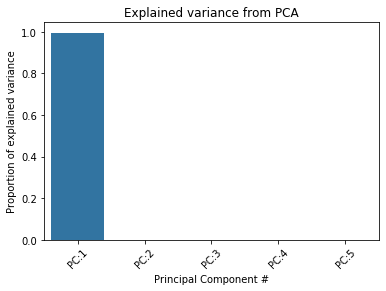

In [0]:
g=sns.barplot(x= ["PC:" + str(w+1) for w in range(len(pca.explained_variance_ratio_))] ,y=pca.explained_variance_ratio_)
plt.xticks(rotation=45)
plt.xlabel('Principal Component #')
plt.ylabel('Proportion of explained variance')
plt.title('Explained variance from PCA')

Most of the variance is explained by 1 component

In [0]:
#add first PC as feature
xpca=pd.DataFrame(reduced[:,1], columns=['pc1'])
xpca.head()

,pc1
0,0.161491
1,0.009323
2,0.336288
3,-0.761104
4,0.185128


In [0]:
X2=pd.concat([X,xpca], axis=1)
X2.shape

(83875, 43)

In [0]:
#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size = 0.25, random_state=1234)

In [0]:
elastic= ElasticNet(random_state=0, normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)


In [0]:
search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [0]:
pred=search.predict(X_test)
sqrt(mean_squared_error(pred,y_test))

0.6181894389402947

Comparing the RMSE of models, adding principal components as features did not improve RMSE on predictions